In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import tensorflow as tf
import string

from tensorflow.keras import layers
from tensorflow.keras import losses


In [3]:
print(tf.__version__)

2.12.0


In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 9s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdbEr.txt', 'train', 'imdb.vocab', 'test', 'README']

In [7]:
train_dir  = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'labeledBow.feat',
 'urls_neg.txt',
 'unsupBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt',
 'pos',
 'unsup']

In [8]:
sample_file =  os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [9]:
#Removing unwanted Directories
remove_dir =  os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


In [12]:
batch_size = 32
seed = 42

raw_train_ds =  tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size =  batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [14]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])


Review b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Label 1
Review b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made for TV.<

In [15]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [16]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [17]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size =  batch_size
)

Found 25000 files belonging to 2 classes.


In [18]:
#Preparing Dataset for Training
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [19]:
max_features = 10000
sequence_length = 250
vectorize_layer =  layers.TextVectorization(
    standardize =  custom_standardization,
    max_tokens =  max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length 
)

In [20]:
#Make Text - only dataset(without labels), then call adapt
train_text =  raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text) 

In [21]:
def vectorize_text(text, label):
  text =  tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [22]:
text_batch, label_batch =  next(iter(raw_train_ds))
first_review , first_label =  text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6992,  248,   32, 1488,    1, 1659,    4,

In [23]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [24]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
#Model Creation
embedding_dim = 16

model =  tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [27]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [28]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 15ms/step - loss: 0.6632 - binary_accuracy: 0.6890 - val_loss: 0.6128 - val_binary_accuracy: 0.7768
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5462 - binary_accuracy: 0.8020 - val_loss: 0.4961 - val_binary_accuracy: 0.8218
Epoch 3/10
625/625 [==============================] - 5s 9ms/step - loss: 0.4431 - binary_accuracy: 0.8457 - val_loss: 0.4190 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3767 - binary_accuracy: 0.8670 - val_loss: 0.3733 - val_binary_accuracy: 0.8602
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3336 - binary_accuracy: 0.8796 - val_loss: 0.3448 - val_binary_accuracy: 0.8680
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3045 - binary_accuracy: 0.8898 - val_loss: 0.3259 - val_binary_accuracy: 0.8710
Epoch 7/10
625/625 [==============================] - 5s 8ms/

In [29]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 9s 12ms/step - loss: 0.3096 - binary_accuracy: 0.8740
Loss:  0.3096452057361603
Accuracy:  0.873960018157959


In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

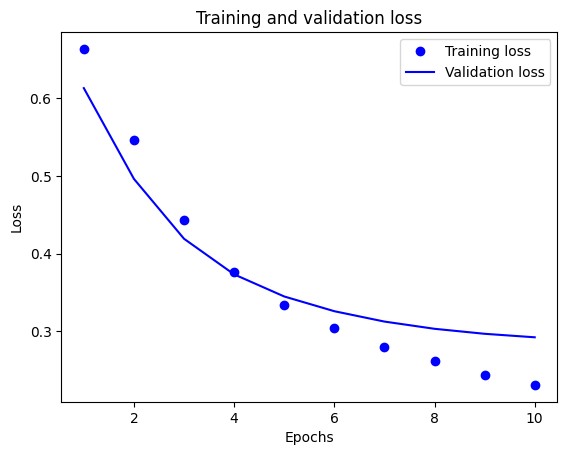

In [31]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

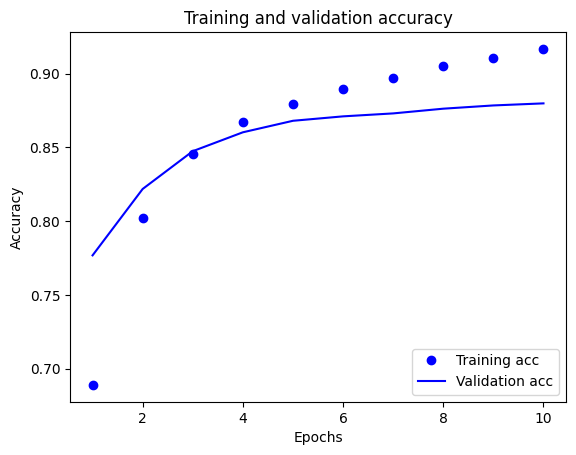

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [33]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3096 - accuracy: 0.8740
0.873960018157959


In [34]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 159ms/step


array([[0.65552115],
       [0.48265588],
       [0.39779368]], dtype=float32)